# Load libraries


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

# Load data

In [2]:
images_dir = os.listdir("../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data")

images_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Images/'
captions_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '../input/flickr8k/145129_343604_upload_Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

# Loading captions as values and images as key in dictionary

In [3]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

# Visualizing

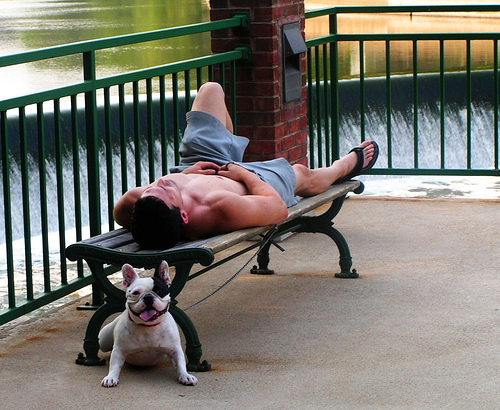

A man lays on a bench while his dog sits by him .
A man lays on the bench to which a white dog is also tied .
a man sleeping on a bench outside with a white and black dog sitting next to him .
A shirtless man lies on a park bench with his dog .
man laying on bench holding leash of dog sitting on ground


In [5]:
temp = captions[19].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

# Creating train, test and validation dataset files with header as image_id and captions

In [6]:
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

# Populating the created files for train, test and validation dataset with image ids and captions for each of these images

In [7]:
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

# Loading ResNet-50

In [8]:
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
# model.summary()

94781440/94765736 [==============================] - 3s 0us/step


# Preprocessing Function

In [9]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [10]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000


In [13]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

# Loading image and its corresponding caption into a dataframe and then storing values 

In [14]:
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values

# Storing all the captions from ds into a list (Sentence)

In [15]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])

# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list

In [16]:
words = [i.split() for i in sentences]

# Creating a list of all unique words

In [17]:
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


# Vectorization

In [18]:
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

# Assigning UNK and raining numerical values

In [19]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

In [20]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'
vocab_size = len(word_2_indices.keys())
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

# Preparing padded input sequences and one-hot encoded target words for training.

In [21]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)

    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1

    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)

padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


(30000,)
(30000,)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [22]:
num_of_images = 2000
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

# Concatenation

In [23]:
for ix in range(num_of_images):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)
print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [24]:
with open('../input/flickr8k/145129_343604_compressed_train_encoded_images.p/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

# Appending Encoded Images

In [25]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0].encode() in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0].encode()]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [26]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])

images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [27]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])

image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


###  **Model**

#Loading Stored captions and Next words

In [28]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)
images = np.load("images.npy")
imag = np.load("image_names.npy")

(25493, 40)
(25493, 8254)


# Embedding Size and Max_len

In [29]:
embedding_size = 128
max_len = 40

#Encoder

In [32]:
# image_model = Sequential()

# image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
# image_model.add(RepeatVector(max_len))

# image_model.summary()
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization

image_model = Sequential([
    Dense(embedding_size, input_shape=(2048,), activation='relu', kernel_regularizer=l2(0.01), name="Dense_Layer"),
    BatchNormalization(name="Batch_Norm_Layer"),
    Dropout(0.3, name="Dropout_Layer"),
    RepeatVector(max_len, name="Repeat_Vector_Layer")
])

image_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_Layer (Dense)          (None, 128)               262272    
_________________________________________________________________
Batch_Norm_Layer (BatchNorma (None, 128)               512       
_________________________________________________________________
Dropout_Layer (Dropout)      (None, 128)               0         
_________________________________________________________________
Repeat_Vector_Layer (RepeatV (None, 40, 128)           0         
Total params: 262,784
Trainable params: 262,528
Non-trainable params: 256
_________________________________________________________________


#Decoder

In [33]:
# language_model = Sequential()

# language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
# language_model.add(LSTM(256, return_sequences=True))
# language_model.add(TimeDistributed(Dense(embedding_size)))

# language_model.summary()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, TimeDistributed, Dropout, BatchNormalization

language_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len, name="Embedding_Layer"),
    LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, name="LSTM_Layer_1"),
    BatchNormalization(name="Batch_Norm_Layer_1"),
    LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3, name="LSTM_Layer_2"),
    BatchNormalization(name="Batch_Norm_Layer_2"),
    TimeDistributed(Dense(embedding_size, activation='relu', name="Dense_Layer"))
])

language_model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 40, 128)           1056512   
_________________________________________________________________
LSTM_Layer_1 (LSTM)          (None, 40, 256)           394240    
_________________________________________________________________
Batch_Norm_Layer_1 (BatchNor (None, 40, 256)           1024      
_________________________________________________________________
LSTM_Layer_2 (LSTM)          (None, 40, 128)           197120    
_________________________________________________________________
Batch_Norm_Layer_2 (BatchNor (None, 40, 128)           512       
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 128)           16512     
Total params: 1,665,920
Trainable params: 1,665,152
Non-trainable params: 768
__________________________________________


# Following code is a concatenated representation of the image and language features, processed through LSTMs, and outputs the predicted next word using a softmax layer — which aligns with the typical encoder-decoder framework used in sequence-to-sequence tasks.

In [34]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Embedding_Layer_input (InputLay [(None, 40)]         0                                            
__________________________________________________________________________________________________
Embedding_Layer (Embedding)     (None, 40, 128)      1056512     Embedding_Layer_input[0][0]      
__________________________________________________________________________________________________
Dense_Layer_input (InputLayer)  [(None, 2048)]       0                                            
__________________________________________________________________________________________________
LSTM_Layer_1 (LSTM)             (None, 40, 256)      394240      Embedding_Layer[0][0]            
______________________________________________________________________________________________

# Training

In [36]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

Epoch 1/200
50/50 [==============================] - 16s 320ms/step - loss: 4.9916 - accuracy: 0.1746
Epoch 2/200
50/50 [==============================] - 16s 320ms/step - loss: 4.6733 - accuracy: 0.2138
Epoch 3/200
50/50 [==============================] - 16s 319ms/step - loss: 4.4933 - accuracy: 0.2316
Epoch 4/200
50/50 [==============================] - 16s 319ms/step - loss: 4.3507 - accuracy: 0.2469
Epoch 5/200
50/50 [==============================] - 16s 319ms/step - loss: 4.2712 - accuracy: 0.2493
Epoch 6/200
50/50 [==============================] - 16s 323ms/step - loss: 4.1683 - accuracy: 0.2550
Epoch 7/200
50/50 [==============================] - 16s 323ms/step - loss: 4.0536 - accuracy: 0.2616
Epoch 8/200
50/50 [==============================] - 16s 327ms/step - loss: 3.9288 - accuracy: 0.2716
Epoch 9/200
50/50 [==============================] - 16s 322ms/step - loss: 3.8131 - accuracy: 0.2798
Epoch 10/200
50/50 [==============================] - 16s 320ms/step - loss: 3.695

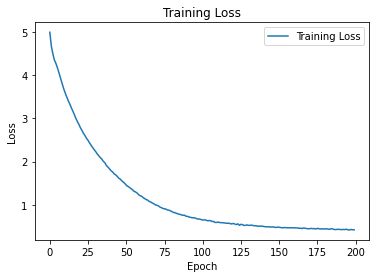

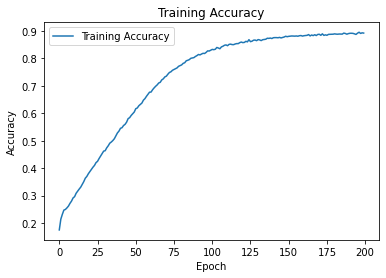

In [53]:
import matplotlib.pyplot as plt

# Plot training loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training accuracy
if 'accuracy' in hist.history:
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
else:
    print("Accuracy data not available in history.")


In [65]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from tqdm.notebook import tqdm

# Function to generate captions
def generate_caption(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices.get(i, word_2_indices['UNK']) for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)], verbose=0)
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break
    
    return ' '.join(start_word[1:-1])

# Function to evaluate BLEU score
def evaluate_bleu_score(model, dataset, images, num_samples=100):
    total_bleu_score = 0.0
    sample_count = min(num_samples, len(dataset))

    for ix in tqdm(range(sample_count)):
        true_caption = dataset[ix, 1].split()
        img_name = dataset[ix, 0]
        image = images[ix]

        # Generate caption
        predicted_caption = generate_caption(image).split()
        
        # Compute BLEU score
        score = sentence_bleu([true_caption], predicted_caption)
        total_bleu_score += score
    
    avg_bleu_score = total_bleu_score / sample_count
    return avg_bleu_score

# Evaluate on a small test set (e.g., 100 samples)
bleu_score = evaluate_bleu_score(model, ds, images, num_samples=100)
print(f"Average BLEU Score: {bleu_score:.4f}")


  0%|          | 0/100 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Average BLEU Score: 0.4213


# Saving The Model

In [42]:
model.save_weights("/kaggle/working/model_weights.h5")

In [43]:
from tensorflow.keras.models import load_model

# Load the previously saved model
model.load_weights("/kaggle/working/model_weights.h5")


# model=MODEL


# Predictions

In [44]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [45]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [46]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [59]:
img = "/kaggle/input/hbkjbk/WhatsApp Image 2025-01-28 at 20.28.54_cef4e6cd.jpg"

test_img = get_encoding(resnet, img)

In [60]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

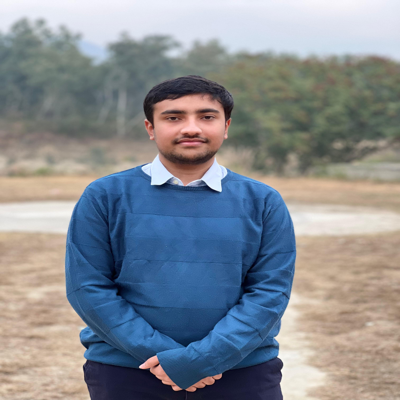


Predicted :
 A young boy in a pool


In [62]:
from PIL import Image
from IPython.display import display

# Open and resize the image
z = Image.open(img)
z = z.resize((400, 400)) 
display(z)

print("\nPredicted :\n", Argmax_Search)


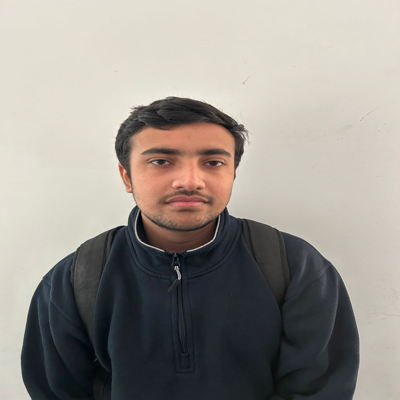


Predicted :
 A boy in a red shirt is next to a blue wall .


In [63]:
img = "/kaggle/input/pictures/WhatsApp Image 2024-12-19 at 23.37.27_48d0eca5.jpg"

test_img = get_encoding(resnet, img)
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)
from PIL import Image
from IPython.display import display

# Open and resize the image
z = Image.open(img)
z = z.resize((400, 400)) 
display(z)

print("\nPredicted :\n", Argmax_Search)


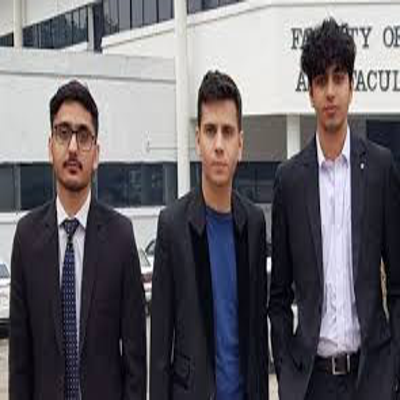


Predicted :
 A group of men are standing around off-camera .


In [64]:
img = "/kaggle/input/asaddd/images (6).jpeg"

test_img = get_encoding(resnet, img)
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_2_indices[i] for i in start_word]
        par_caps = sequence.pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_2_word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)
from PIL import Image
from IPython.display import display

# Open and resize the image
z = Image.open(img)
z = z.resize((400, 400)) 
display(z)

print("\nPredicted :\n", Argmax_Search)


# Prediction From the CNN + LSTM Model


# **Report on Image Captioning using CNN and LSTM**

---

## **1. Methodology**
This project implements an **image captioning model** using a **CNN-LSTM architecture**. The goal is to generate meaningful captions for input images by combining visual and textual data. The methodology involves:  

1. **Preprocessing**  
   - Load and preprocess the Flickr8k dataset (images and captions).  
   - Tokenize and encode captions into numerical format.  
   - Extract features from images using a pretrained CNN (ResNet-50).  

2. **Model Design**  
   - Use a CNN (ResNet-50) to extract image features.  
   - Use an LSTM-based language model to generate captions.  
   - Combine the outputs of CNN and LSTM for final word prediction.  

3. **Training and Evaluation**  
   - Train the model using categorical cross-entropy loss.
   - 90% accuracy was gained during mode training.
   - Optimize using RMSprop optimizer.
   - Evaluated on Random Images (Results are attached at the end).
   - Evaluate using training and loss curves.
   - Evaluated on BLEU scores which is 0.4213 which is pretty good for image captioing model.
   -  

---

## **2. Dataset Details**
- **Dataset**: Flickr8k  
- **Training Size**: 6000+ images 
- **Captions**: Each image is paired with five captions.  

---

## **3. Preprocessing**
### **Image Preprocessing**  
1. Loaded the Flickr8k dataset.  
2. Resized images to **(224, 224, 3)** for ResNet-50 compatibility.  
3. Extracted image features using a pretrained ResNet-50 model (without the final layer).  
4. Stored extracted features in a dictionary using `pickle` for faster access.  

**Example Code:**  
```python
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im




## **4. Model Architecture**
### **Architecture Overview**  
The architecture consists of two main components:  

1. **Encoder (CNN)**  
   - Pretrained ResNet-50 (excluding the final classification layer).  
   - The output is passed through a Dense layer to reduce dimensionality.  
   - RepeatVector is used to adjust the output shape to match the LSTM input.  

2. **Decoder (LSTM)**  
   - Takes the tokenized captions as input.  
   - Embedding layer converts input indices to dense vectors.  
   - LSTM layers process the sequences and generate context-aware outputs.  
   - A dense layer with softmax activation generates the next word in the sequence.  

---

### **Image Model**  
- The image model extracts features from input images using a Dense layer and prepares them for sequence generation using RepeatVector.  
- Batch normalization and dropout are used to improve generalization and prevent overfitting.  

**Example Code:**  
```python
image_model = Sequential([
    Dense(embedding_size, input_shape=(2048,), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    RepeatVector(max_len)
])


# Results from Captioning Model
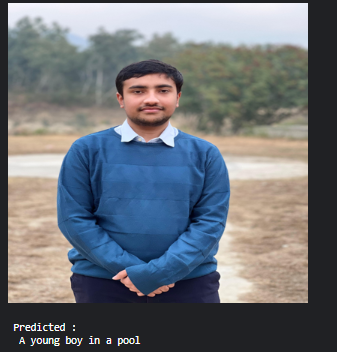
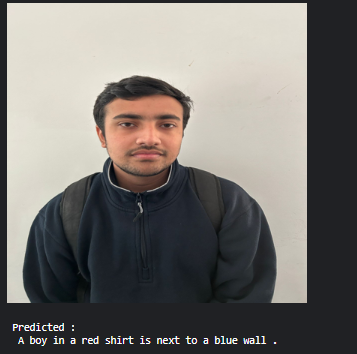
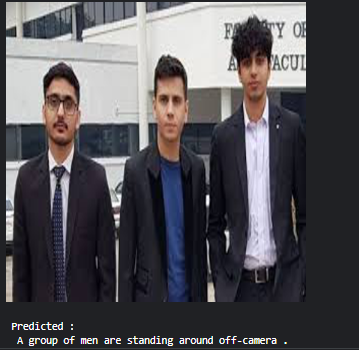